### Starbucks Capstone Project

# Part I. Data Exploration

**This notebook is Part I of Starbucks Capstone Project**
1. Project Definition
    - Project Overview
    - Problem Statement
    - Metrics
2. Analysis
    - Data Exploration
    - Data Visualization   

## 1.1 Project Overview

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks.

Not all users receive the same offer, and that is the challenge to solve with this data set.

Our task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

We'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer.

We should keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#import zipfile
#with zipfile.ZipFile("data.zip","r") as zip_ref:
    #zip_ref.extractall()

In [2]:
# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

In [3]:
portfolio.to_csv('portfolio.csv')
profile.to_csv('profile.csv')
transcript.to_csv('transcript.csv')

### Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)


In [4]:
print('shape:', portfolio.shape)
portfolio
#This is a simple data with 10 rows and 6 columns about the offers

shape: (10, 6)


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income


In [5]:
print('shape:', profile.shape)
profile.head()
#This data set is about the customers profile, like age, gender...

shape: (17000, 5)


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [6]:
print('shape:', transcript.shape)
transcript.head()
#This data set is the offers that we sent to customers and details of this offers send.

shape: (306534, 4)


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


## 1.2 Problem Definition
After we see the datasets, there are some questions should be answered.
 * What is the results of offers sended?
 * Can we predict given an offer to a profile will be completed?

## 1.3 Metrics

Since we are going to use a claasification, we will use accuracy and roc_auc score for evaluation.



## 1.4 Data Exploration


**Profile Dataset**

In [7]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [8]:
len(profile.id.unique())

17000

**Given in the dataset** that the null value for **age is 118**, and there are some missing values at **"gender" and "income"** columns.**

We will try to visualize this **Nan** values.

Plot **"age" distribution**

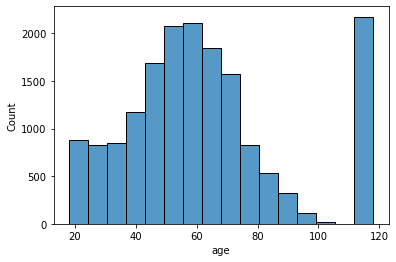

In [9]:
age_hist = sns.histplot(data=profile, x="age", bins =16)
fig = age_hist.get_figure()
fig.savefig('age.png')

Plot **income distribution**

<AxesSubplot:xlabel='income', ylabel='Count'>

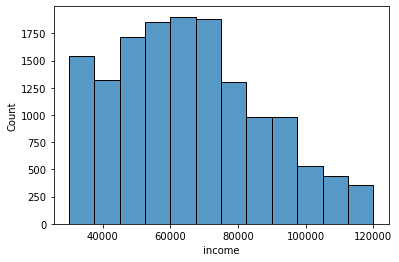

In [10]:
sns.histplot(profile['income'].dropna(), bins = 12)

In [11]:
#Fill null values with U for visualization
profile.gender.fillna(value='U', inplace=True)

Plot **gender distribution**

<AxesSubplot:xlabel='gender', ylabel='count'>

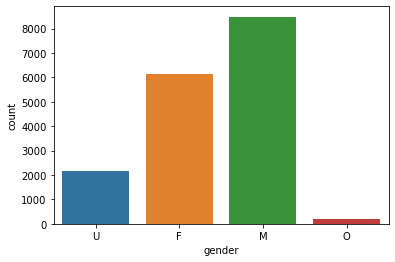

In [12]:
sns.countplot(x='gender', data=profile)


**Null values:**

There are 2175 missing values in common for 'age', 'gender', and 'income'. Probably these Profiles are not completed.
We will try to thread these missing values, when we are preparing the data.

**Datetime**:
the last info to deal with is the 'became-member-on'. I will convert this info to date time and also try to calculate the total days of membership.

In [13]:
#First use pandas datetime to format datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
last_date_df=profile.sort_values(by='became_member_on')
#Find last date
last_date = last_date_df['became_member_on'].iloc[-1]

In [14]:
#Subtract from last date for days since member
profile['days_member'] =  (last_date-profile['became_member_on']).dt.days
profile.head()

,gender,age,id,became_member_on,income,days_member
0,U,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,529
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,376
2,U,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,14
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,443
4,U,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,356


Plot **days since membership**

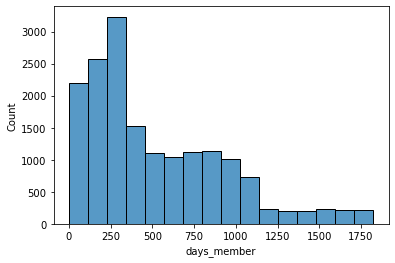

In [15]:
member_hist = sns.histplot(x='days_member', data = profile, bins=16)

In [16]:
profile.describe()

,age,income,days_member
count,17000.000000,14825.000000,17000.000000
mean,62.531412,65404.991568,517.449882
std,26.738580,21598.299410,411.223904
min,18.000000,30000.000000,0.000000
25%,45.000000,49000.000000,208.000000
50%,58.000000,64000.000000,358.000000
75%,73.000000,80000.000000,791.000000
max,118.000000,120000.000000,1823.000000


**Transcript Dataset**

In [17]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


This data is an event data which record an event of a person at a time. An record the value of this event in 'value' column in a dict format.

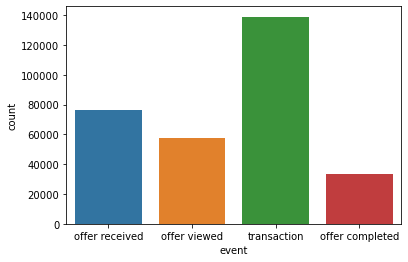

In [18]:
event=sns.countplot(x='event', data=transcript)

There are 4 different events; basic scenario is you received and offer (one from the portfolio data), you viewed the offer, you made the transaction and the offer is completed, you get the reward. The tricky part is :
    - Some offers are not reward related.
    - Some transactions are not offer related.

In [19]:
transcript['value']

0         {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2         {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3         {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4         {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
                                ...                       
306529                      {'amount': 1.5899999999999999}
306530                                    {'amount': 9.53}
306531                                    {'amount': 3.61}
306532                      {'amount': 3.5300000000000002}
306533                                    {'amount': 4.05}
Name: value, Length: 306534, dtype: object

The **value** column is a little bit tricky.
 - You will get 'offer id' for events of recieved and completed
 - You will get 'offer_id' & 'reward' for event completed
 - You will get 'amount' for event transaction.
 
I will try to encode this with below functions.

In [20]:
def encode_offer_id(x):
    try :
        return x['offer id']
    except:
        return x['offer_id']

def transcript_encoded(transcript_df):
    '''
        Takes transcript dataframe, get a copy, encode 'offer_id' column,
        create 'amount' and 'reward' columns from dictionary keys.
        '''
   
    
    transcript_encoded = transcript_df.copy()
    transcript_encoded['offer_id'] = transcript[transcript.event.isin(
        ['offer received', 'offer viewed', 'offer completed'])].value.apply(encode_offer_id)
    transcript_encoded['amount'] = transcript_encoded['value'].apply(lambda x: x.get('amount'))
    transcript_encoded['reward'] = transcript_encoded['value'].apply(lambda x: x.get('reward'))
    return transcript_encoded

df_encoded=transcript_encoded(transcript)

In [21]:
df_encoded.head()

,person,event,value,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


**Seperating transaction and other events**

In [22]:
df_encoded_transaction = df_encoded[df_encoded.event == 'transaction'].drop(columns='offer_id')
df_encoded_event = df_encoded[df_encoded.event != 'transaction']
df_encoded_transaction.head()

,person,event,value,time,amount,reward
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0,0.83,NaN
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0,34.56,NaN
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0,13.23,NaN
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0,19.51,NaN
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0,18.97,NaN


This data is an event data with time so , I will lastly look for the seasonality between offer viewed and the transaction amount by time.

In [23]:
#The amount of transaction in time domain.
df_tran_sum= df_encoded_transaction.groupby(['time'])['amount'].sum().to_frame('sum')
df_tran_sum.head()

,sum
time,
0,7305.57
6,9923.66
12,12859.51
18,13961.60
24,11559.57


In [24]:
df_event_count = pd.get_dummies(df_encoded_event, columns=['event'])
df_event_viewed=df_event_count.groupby(['time'])\
                        ["event_offer viewed"]\
                        .count().to_frame('count')

**Seasonality between offers viewed, transaction amount**

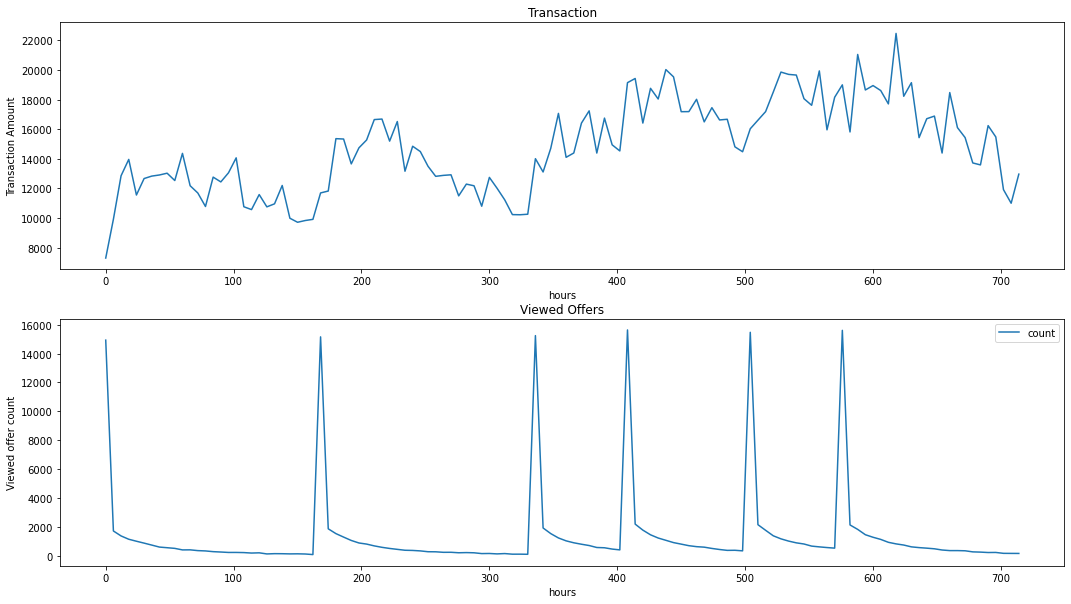

In [25]:
fig, ax = plt.subplots(2, figsize=(18,10))


ax[0].plot(df_tran_sum, label='sum')
ax[1].plot(df_event_viewed, label='count')
ax[0].set_xlabel('hours')
ax[0].set_ylabel('Transaction Amount')
ax[0].set_title('Transaction')
ax[1].set_xlabel('hours')
ax[1].set_ylabel('Viewed offer count')
ax[1].set_title('Viewed Offers')
plt.legend(loc='best')
plt.show()

As the amount of viewed increases , it is followed by the increase in transaction amount.